<img src="https://www.science.org.au/curious/sites/default/files/article-banner-image/planets-banner.jpg" style="max-height:200px;"></img>

# Exploring data on Spotify

This notebook includes my code for collecting, manipulating, and analyzing Spotify data based on an album. I also describe my design process and thoughts that would influence my final product in D3.js.

### Table of Contents
* [Background](#background)
* [Spotify Data](#data)
* [Exploratory Analysis](#exploratory)
    * [Mars](#mars)
    * [Jupiter](#jupiter)

---

<a id="background"></a>
### Background
Gustav Holst composed a symphony for orchestra called **The Planets** between 1914 and 1916. I found [this album](https://open.spotify.com/album/4v0Xyz0LVToUsSTGdsvKSK?si=Cz-2yavOQ-OZASBjfu9ZTw) played by the Berlin Philharmonic on Spotify, which contains all 7 movements. Each section describes a planet based on its [astrological character](https://en.wikipedia.org/wiki/Planets_in_astrology).

    I.   Mars, the Bringer of War (1914)
    II.  Venus, the Bringer of Peace (1914)
    III. Mercury, the Winged Messenger (1916)
    IV.  Jupiter, the Bringer of Jollity (1914)
    V.   Saturn, the Bringer of Old Age (1915)
    VI.  Uranus, the Magician (1915)
    VII. Neptune, the Mystic (1915)
    
While frequently played in concerts, as remixes, and in movies, the original arrangement of The Planets, particularly **Jupiter**, is still one of my favorite pieces. In youth orchestra, we often played the majestic part of Jupiter to end rehearsal on a good note. :)

In [1]:
# Load extension for formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

---

<a id="data"></a>
### Spotify Data
Having [experience on a past project](https://spotify-flowers.herokuapp.com/) with the [Spotify Web API](https://developer.spotify.com/documentation/web-api/reference/), I used it again to get data on each of the movements. The Web API includes a [Tracks API](https://developer.spotify.com/documentation/web-api/reference/#category-tracks) which has data on the tracks' audio feature and audio analysis. While the [Spotipy](https://spotipy.readthedocs.io/en/2.18.0/) Python library exists, I wanted to try using `requests` for practice. A lot of help came from reading through their [source code](https://github.com/plamere/spotipy). 

In [2]:
# Import libraries
import configparser
import requests
import json
import base64
import re

<IPython.core.display.Javascript object>

#### Authorizing the app
To begin using the Spotify Web API, I got my **Client ID** and **Client Secret** by [registering my app](https://developer.spotify.com/documentation/general/guides/app-settings/#register-your-app). Then I authorized the app using [Client Credentials Flow](https://developer.spotify.com/documentation/general/guides/authorization-guide/#client-credentials-flow) using a `POST` request with given parameters. This returns an **access token**.

In [3]:
# Get parameters from config file
config = configparser.ConfigParser()
config.read_file(open("app.cfg"))
CLIENT_ID = config.get("SPOTIFY", "CLIENT_ID")
CLIENT_SECRET = config.get("SPOTIFY", "CLIENT_SECRET")
OAUTH_TOKEN_URL = config.get("SPOTIFY", "OAUTH_TOKEN_URL")

# Set body parameters
body = {"grant_type": "client_credentials"}

# Set headers in the format: Authorization: Basic <base64 encoded client_id:client_secret>
base64_encoded = base64.b64encode(
    bytes((CLIENT_ID + ":" + CLIENT_SECRET).encode())
).decode()
headers = {"Authorization": f"Basic {base64_encoded}"}

# Build a new session
session = requests.Session()

# Get response
response = session.post(
    OAUTH_TOKEN_URL,
    data=body,
    headers=headers,
)

# Get status code and access token
if response.ok:
    print(f"Status code: {response.status_code}")
    access_token = response.json()["access_token"]

Status code: 200


<IPython.core.display.Javascript object>

Create a function for making `GET` requests based on the access token.

In [4]:
def get_request(endpoint_type: str, id: str, access_token: str = access_token):
    """Makes GET request for a given Spotify Web API.
    Parameters
    ----------
    endpoint_type : str
        Name of API
    id : str
        ID
    access_token: str
        Access token

    Returns
    ----------
    dict
        Response in JSON
    """
    assert endpoint_type in [
        "albums",
        "tracks",
        "audio-features",
        "audio-analysis",
    ], "Not a valid endpoint."

    endpoint = f"https://api.spotify.com/v1/{endpoint_type}/{id}"
    headers = {"Authorization": f"Bearer {access_token}"}

    response = session.get(
        endpoint,
        headers=headers,
    )

    assert response.ok, "Status : {}".format(response.status_code)
    return response.json()

<IPython.core.display.Javascript object>

#### Album API
The URI for the album "Holst: The Planets" is `4v0Xyz0LVToUsSTGdsvKSK`.

In [5]:
album = get_request("albums", "4v0Xyz0LVToUsSTGdsvKSK")

print("URL:", album["external_urls"]["spotify"])
print("Label:", album["label"])
print("Release Date:", album["release_date"])
print("Popularity:", album["popularity"])

URL: https://open.spotify.com/album/4v0Xyz0LVToUsSTGdsvKSK
Label: Deutsche Grammophon (DG)
Release Date: 1981-01-01
Popularity: 45


<IPython.core.display.Javascript object>

In [6]:
# Get list of track URIs
track_ids = []
items = album["tracks"]["items"]
for item in items:
    track_ids.append(item["id"])

<IPython.core.display.Javascript object>

#### Tracks API
This includes general track data, [audio feature](https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject), and audio analysis.

In [27]:
tracks = []
for track_id in track_ids:
    track = get_request("tracks", track_id)
    audio_features = get_request("audio-features", track_id)
    audio_analysis = get_request("audio-analysis", track_id)

    tracks.append(
        {
            "trackNumber": track["track_number"],
            "planet": re.search("(?<=[1-7]\. )([a-zA-Z]+)(?=,)", track["name"]).group(),
            "description": re.search("(?<=, )([a-zA-Z ]+)$", track["name"]).group(),
            "name": track["name"],
            "url": track["external_urls"]["spotify"],
            "popularity": track["popularity"],
            "duration": track["duration_ms"] / 1000,
            "tempo": audio_features["tempo"],
            "tempoConfidence": audio_analysis["track"]["tempo_confidence"],
            "timeSignature": audio_features["time_signature"],
            "timeSignatureConfidence": audio_analysis["track"][
                "time_signature_confidence"
            ],
            "key": audio_features["key"],
            "keyConfidence": audio_analysis["track"]["key_confidence"],
            "mode": audio_features["mode"],
            "modeConfidence": audio_analysis["track"]["mode_confidence"],
            "danceability": audio_features["danceability"],
            "energy": audio_features["energy"],
            "loudness": audio_features["loudness"],
            "valence": audio_features["valence"],
            "acousticness": audio_features["acousticness"],
            "instrumentalness": audio_features["instrumentalness"],
            "analysis": {
                "sections": audio_analysis["sections"],
                "bars": audio_analysis["bars"],
                "beats": audio_analysis["beats"],
                "tatums": audio_analysis["tatums"],
                "segments": audio_analysis["segments"],
            },
        }
    )

    print(track["name"], track["external_urls"]["spotify"])

The Planets, Op. 32: 1. Mars, the Bringer of War https://open.spotify.com/track/1C3RIRKQZhSk5d2iioIhkg
The Planets, Op. 32: 2. Venus, the Bringer of Peace https://open.spotify.com/track/0kEBYD0sMCPtsfpwFLG9aj
The Planets, Op. 32: 3. Mercury, the Winged Messenger https://open.spotify.com/track/4rehJ6QJSNLQCK3Rav7pAe
The Planets, Op. 32: 4. Jupiter, the Bringer of Jollity https://open.spotify.com/track/59Id4KrBWiizuq53doxWtp
The Planets, Op. 32: 5. Saturn, the Bringer of Old Age https://open.spotify.com/track/6JN1TOTbij0lynXvKNUlFw
The Planets, Op. 32: 6. Uranus, the Magician https://open.spotify.com/track/47fxroOKrDiF1KGNnuUFqr
The Planets, Op. 32: 7. Neptune, the Mystic https://open.spotify.com/track/1MUMbwhbg0ym7jt6nTeXk8


<IPython.core.display.Javascript object>

In [28]:
# Save as JSON file
with open("data.json", "w") as file:
    json.dump(tracks, file)

<IPython.core.display.Javascript object>

---

<a id="exploratory"></a>
### Exploratory Analysis
Although I already have an idea for how the visual should look, I did some initial discoveries in `Matplotlib` instead of D3. This process helps me look out for anomalies or trends that would cause the visual to not look as good as planned. Sometimes I would find insights by doing more scratch work that I would later include in the final version.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

plt.style.use("fun")
%matplotlib inline

In [2]:
# Read data
with open("data.json", "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)
df.head(1)

,trackNumber,planet,description,name,url,popularity,duration,tempo,tempoConfidence,timeSignature,...,keyConfidence,mode,modeConfidence,danceability,energy,loudness,valence,acousticness,instrumentalness,analysis
0,1,Mars,the Bringer of War,"The Planets, Op. 32: 1. Mars, the Bringer of War",https://open.spotify.com/track/1C3RIRKQZhSk5d2...,38,441.0,148.689,0.0,5,...,0.528,1,0.578,0.222,0.478,-10.759,0.0756,0.83,0.887,"{'sections': [{'start': 0.0, 'duration': 24.75..."


#### Comparing all movements

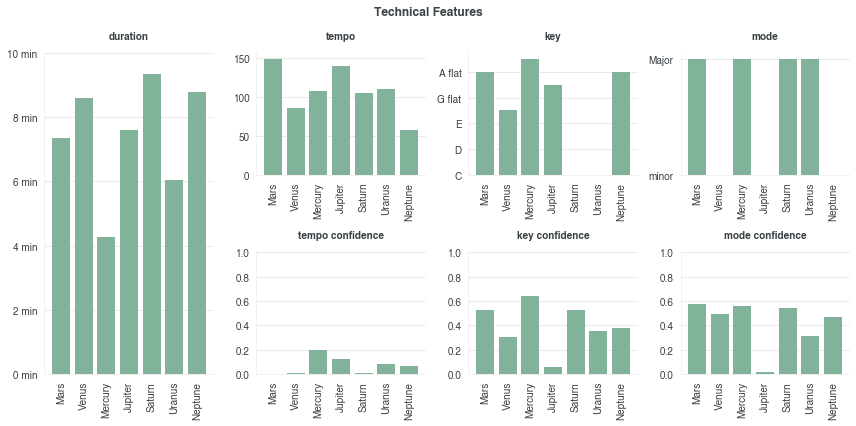

In [3]:
features = ["duration", "tempo", "key", "mode"]

fig = plt.figure(figsize=[12, 6])
fig.suptitle("Technical Features")
gs = fig.add_gridspec(2, len(features))

for index, feature in enumerate(features):

    if feature == "duration":
        end = 2
    else:
        end = 1

    ax = fig.add_subplot(gs[0:end, index])
    ax.set_title(feature)

    ax.bar(x=df.planet, height=df[feature])

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    if feature == "duration":
        ax.set_yticks(np.arange(0, 601, 120))
        ax.set_yticklabels([f"{m} min" for m in np.arange(0, 12, 2)])
    if feature == "key":
        ax.set_yticks(np.arange(0, 10, 2))
        ax.set_yticklabels(["C", "D", "E", "G flat", "A flat"])
    if feature == "mode":
        ax.set_yticks(np.arange(0, 2, 1))
        ax.set_yticklabels(["minor", "Major"])

    if feature == "duration":
        continue
    ax = fig.add_subplot(gs[1, index])
    ax.set_title(feature + " confidence")
    ax.bar(x=df.planet, height=df[feature + "Confidence"])
    ax.set_ylim(0, 1)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

plt.savefig("../img/technical_features.png")

* Duration is the only reliable metric with Mercury being the shortest. Most pieces are roughly 8 minutes long. 
* Tempo is not a useful metric, since it doesn't reflect fast passages or overall energy. 
* Key and mode have very low confidence and some are incorrect (Mars is definitely not Major, although it's not minor either). However, Venus (f minor) and Jupiter (a minor) are correct, since they are easier to tell.

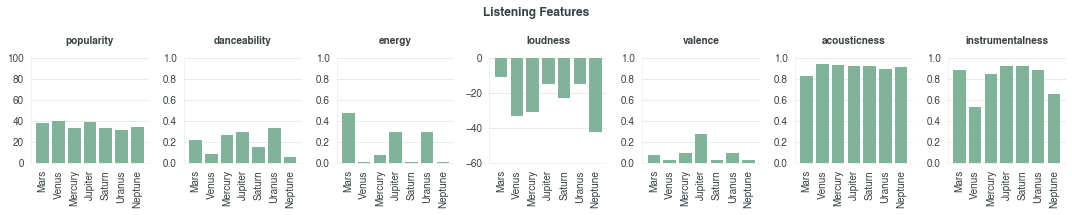

In [4]:
features = [
    "popularity",
    "danceability",
    "energy",
    "loudness",
    "valence",
    "acousticness",
    "instrumentalness",
]

fig, axes = plt.subplots(1, len(features), figsize=[15, 3])
fig.suptitle("Listening Features")

for index, feature in enumerate(features):

    ax = axes[index]
    ax.set_title(feature)

    ax.bar(x=df.planet, height=df[feature])
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    if feature in ["popularity"]:
        ax.set_ylim(0, 100)
    elif feature in [
        "danceability",
        "energy",
        "valence",
        "acousticness",
        "instrumentalness",
    ]:
        ax.set_ylim(0, 1)
    else:
        ax.set_ylim(-60, 0)

plt.savefig("../img/listening_features.png")

* Classical music isn't super popular on Spotify, but the relative popularities are helpful. I knew Jupiter and Mars were the most played but didn't know that Venus was too. 
* Danceability is not a good interpretation for classical music but is perfect for other genres like hip-hop. I'll ignore this...
* Energy is also not so good for classical. It seems like the pieces with fast passages and "liveliness" have some energy while pieces with notes held out are pretty dead. 
* [Loudness](https://artists.spotify.com/help/article/loudness-normalization) could be useful, and Mars is the loudest and most aggressive piece. The pattern is similar to Spotify's audio feature for energy, but has more details for comparing different planets. Mars, Jupiter, and Uranus have the highest loudness because they have entire orchestra and brass features.
* Valence describes positivity, and it looks like Spotify thinks this symphony is depressing (just kidding). Jupiter is the most joyful. 
* I plotted acousticness and instrumentalness for fun, but they should be near 1.0 as they are orchestral pieces.

In summary, **popularity** and **loudness** can be used for comparisons.

<a id="mars"></a>
#### Mars

In [5]:
PITCHES = [
    "C",
    "C#",
    "D",
    "D#",
    "E",
    "F",
    "F#",
    "G",
    "G#",
    "A",
    "A#",
    "B",
]

In [6]:
mars = df[df.trackNumber == 1].iloc[0]

mars_sections = pd.DataFrame(mars["analysis"]["sections"])
mars_bars = pd.DataFrame(mars["analysis"]["bars"])
mars_beats = pd.DataFrame(mars["analysis"]["beats"])
mars_tatums = pd.DataFrame(mars["analysis"]["tatums"])
mars_segments = pd.DataFrame(mars["analysis"]["segments"])

mars_pitches = pd.DataFrame(
    mars_segments["start"] + 0.5 * mars_segments["duration"], columns=["start"]
).join(mars_segments["pitches"].apply(pd.Series))
mars_pitches.columns = ["start"] + PITCHES

mars_pitches = pd.DataFrame(mars_segments[["start", "duration"]]).join(
    mars_segments["pitches"].apply(pd.Series)
)
mars_pitches.columns = ["start", "duration"] + PITCHES

mars_timbre = pd.DataFrame(mars_segments[["start", "duration"]]).join(
    mars_segments["timbre"].apply(pd.Series)
)
mars_timbre.columns = ["start", "duration"] + PITCHES

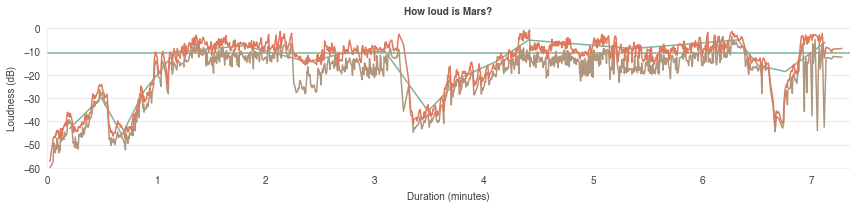

In [7]:
fix, ax = plt.subplots(1, figsize=[12, 3])

ax.set_title("How loud is Mars?")
ax.set_xlim(0, mars["duration"])
ax.set_xticks(np.arange(0, mars["duration"], 60))
ax.set_xticklabels([int(s / 60) for s in np.arange(0, mars["duration"], 60)])
ax.set_xlabel("Duration (minutes)")

ax.set_ylim(-60, 0)
ax.set_ylabel("Loudness (dB)")

ax.axhline(mars["loudness"])
ax.plot(
    mars_sections["start"] + 0.5 * mars_sections["duration"],
    mars_sections["loudness"],
)
ax.plot(
    mars_segments["start"] + 0.5 * mars_segments["duration"],
    mars_segments["loudness_start"],
)
ax.plot(
    mars_segments["start"] + 0.5 * mars_segments["duration"],
    mars_segments["loudness_max"],
)

plt.show()

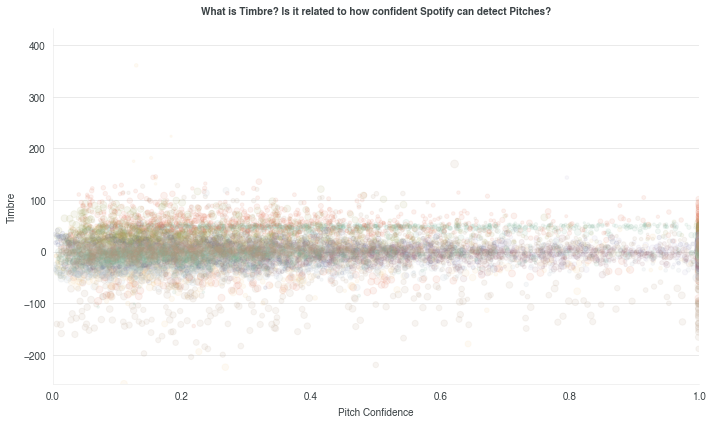

In [8]:
fix, ax = plt.subplots(1, figsize=[10, 6])

ax.set_title(
    "What is Timbre? Is it related to how confident Spotify can detect Pitches?"
)

ax.set_xlim(0, 1)
ax.set_xlabel("Pitch Confidence")

ax.set_ylim(np.min(np.min(mars_timbre)), np.max(np.max(mars_timbre)))
ax.set_ylabel("Timbre")

for pitch in PITCHES:
    ax.scatter(
        mars_pitches[pitch],
        mars_timbre[pitch],
        alpha=0.1,
        s=-mars_segments["loudness_start"],
    )
plt.savefig("../img/mars_timbre_pitches_correlation.png")

There's no documentation on timbre, and it's usually not a numerical metric. It's not correlated to the chroma vector either.

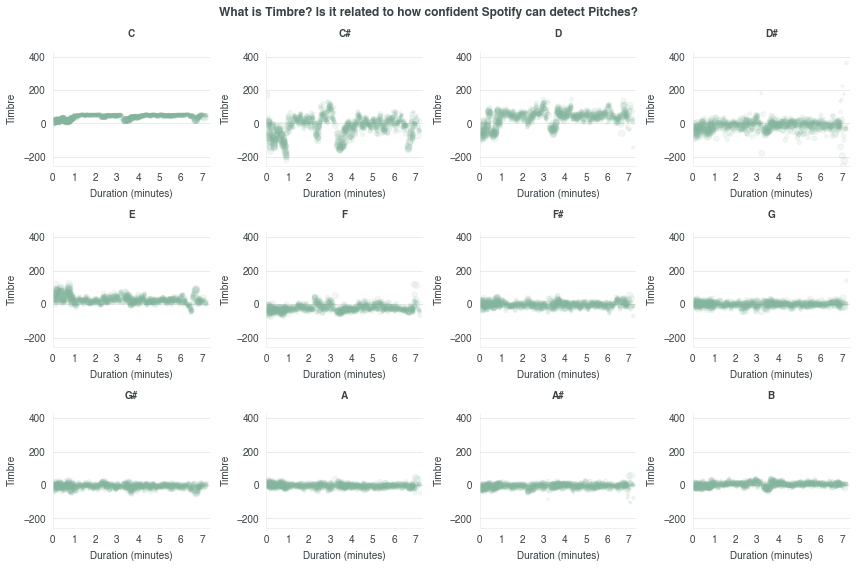

In [9]:
fix, axes = plt.subplots(3, 4, figsize=(12, 8))
axes = axes.flatten()

plt.suptitle(
    "What is Timbre? Is it related to how confident Spotify can detect Pitches?"
)

for index, ax in enumerate(axes):
    pitch = PITCHES[index]

    ax.set_title(pitch)

    ax.set_xlim(0, mars["duration"])
    ax.set_xticks(np.arange(0, mars["duration"], 60))
    ax.set_xticklabels([int(s / 60) for s in np.arange(0, mars["duration"], 60)])
    ax.set_xlabel("Duration (minutes)")

    ax.set_ylim(np.min(np.min(mars_timbre)), np.max(np.max(mars_timbre)))
    ax.set_ylabel("Timbre")

    ax.scatter(
        mars_timbre["start"],
        mars_timbre[pitch],
        alpha=0.1,
        s=-mars_segments["loudness_start"],
    )

plt.savefig("../img/mars_timbre_by_pitches.png")

I'm still not sure the timbre metric means. Besides C#, the pitches have a normal timbre (hovering around 0), but maybe it's because Mars is a pretty homogenous piece. I'm not sure why C# is so wild.

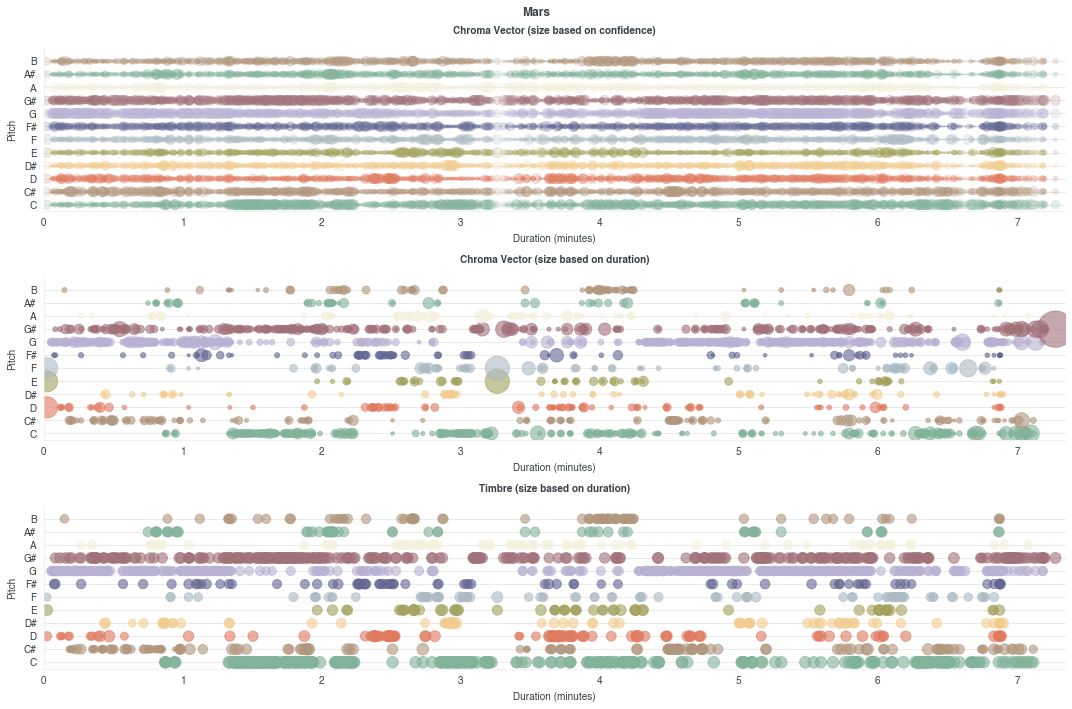

In [10]:
fix, axes = plt.subplots(3, 1, figsize=[15, 10])
plt.suptitle("Mars")

for ax in axes:
    ax.set_xlim(0, mars["duration"])
    ax.set_xticks(np.arange(0, mars["duration"], 60))
    ax.set_xticklabels([int(s / 60) for s in np.arange(0, mars["duration"], 60)])
    ax.set_xlabel("Duration (minutes)")

    ax.set_ylim(-0.5, 12)
    ax.set_yticks(np.arange(0, 12))
    ax.set_yticklabels(PITCHES)
    ax.set_ylabel("Pitch")

axes[0].set_title("Chroma Vector (size based on confidence)")
for index, pitch in enumerate(PITCHES):
    p = mars_pitches
    axes[0].scatter(
        x=p["start"] + 0.5 * p["duration"],
        y=np.repeat(index, p.shape[0]),
        s=100 * p[pitch],
        alpha=0.2,
    )

axes[1].set_title("Chroma Vector (size based on duration)")
for index, pitch in enumerate(PITCHES):
    # Filter pitches to have a threshold of 80% because Matplotlib doesn't support dynamic alpha
    p = mars_pitches[mars_pitches[pitch] > 0.8]
    axes[1].scatter(
        x=p["start"] + 0.5 * p["duration"],
        y=np.repeat(index, p.shape[0]),
        s=150 * p["duration"],
        alpha=0.6,
    )

axes[2].set_title("Timbre (size based on duration)")
for index, pitch in enumerate(PITCHES):
    # Filter pitches to have a threshold of 80% because Matplotlib doesn't support dynamic alpha
    p = mars_timbre[mars_pitches[pitch] > 0.8]
    axes[2].scatter(
        x=p["start"] + 0.5 * p["duration"],
        y=np.repeat(index, p.shape[0]),
        s=300
        / (np.max(np.max(p)) - np.min(np.min(p)))
        * (p[pitch] - np.min(np.min(p))),
        alpha=0.6,
    )

plt.savefig("../img/mars_chroma.png")

For making a visualization, using a threshold for the chroma feature like in the second chart is cleaner. I would probably also combine loudness (as alpha). The third chart doesn't make sense at all, and I shouldn't blend timbre with pitch without knowing what the timbre metric is.

<a id="jupiter"></a>
#### Jupiter
The MuseScore is [here](https://musescore.com/user/6543201/scores/5063369).

In [11]:
jupiter = df[df.trackNumber == 4].iloc[0]

jupiter_sections = pd.DataFrame(jupiter["analysis"]["sections"])
jupiter_bars = pd.DataFrame(jupiter["analysis"]["bars"])
jupiter_beats = pd.DataFrame(jupiter["analysis"]["beats"])
jupiter_tatums = pd.DataFrame(jupiter["analysis"]["tatums"])
jupiter_segments = pd.DataFrame(jupiter["analysis"]["segments"])

jupiter_pitches = pd.DataFrame(
    jupiter_segments["start"] + 0.5 * jupiter_segments["duration"], columns=["start"]
).join(jupiter_segments["pitches"].apply(pd.Series))
jupiter_pitches.columns = ["start"] + PITCHES

jupiter_pitches = pd.DataFrame(jupiter_segments[["start", "duration"]]).join(
    jupiter_segments["pitches"].apply(pd.Series)
)
jupiter_pitches.columns = ["start", "duration"] + PITCHES

jupiter_timbre = pd.DataFrame(jupiter_segments[["start", "duration"]]).join(
    jupiter_segments["timbre"].apply(pd.Series)
)
jupiter_timbre.columns = ["start", "duration"] + PITCHES

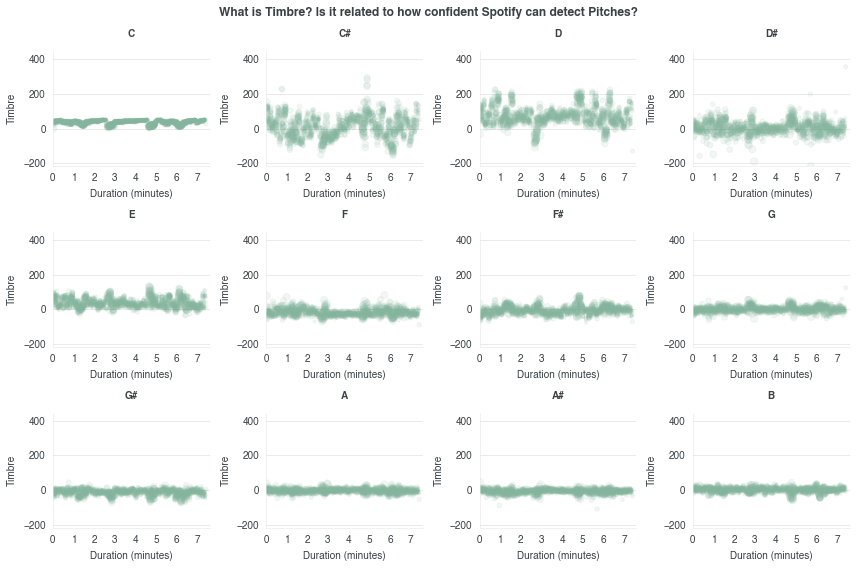

In [12]:
fix, axes = plt.subplots(3, 4, figsize=[12, 8])
axes = axes.flatten()

plt.suptitle(
    "What is Timbre? Is it related to how confident Spotify can detect Pitches?"
)

for index, ax in enumerate(axes):
    pitch = PITCHES[index]

    ax.set_title(pitch)

    ax.set_xlim(0, jupiter["duration"])
    ax.set_xticks(np.arange(0, jupiter["duration"], 60))
    ax.set_xticklabels([int(s / 60) for s in np.arange(0, jupiter["duration"], 60)])
    ax.set_xlabel("Duration (minutes)")

    ax.set_ylim(np.min(np.min(jupiter_timbre)), np.max(np.max(jupiter_timbre)))
    ax.set_ylabel("Timbre")

    ax.scatter(
        jupiter_timbre["start"],
        jupiter_timbre[pitch],
        alpha=0.1,
        s=-jupiter_segments["loudness_start"],
    )

plt.savefig("../img/jupiter_timbre_by_pitches.png")

Even with Jupiter, timbre doesn't seem like a good indication. The piece is in a minor (relative C), and doesn't use as many C-sharps. Jupiter also has various instrument compositions by section, which is not reflected in the audio analysis. I am going to disregard timbre entirely.

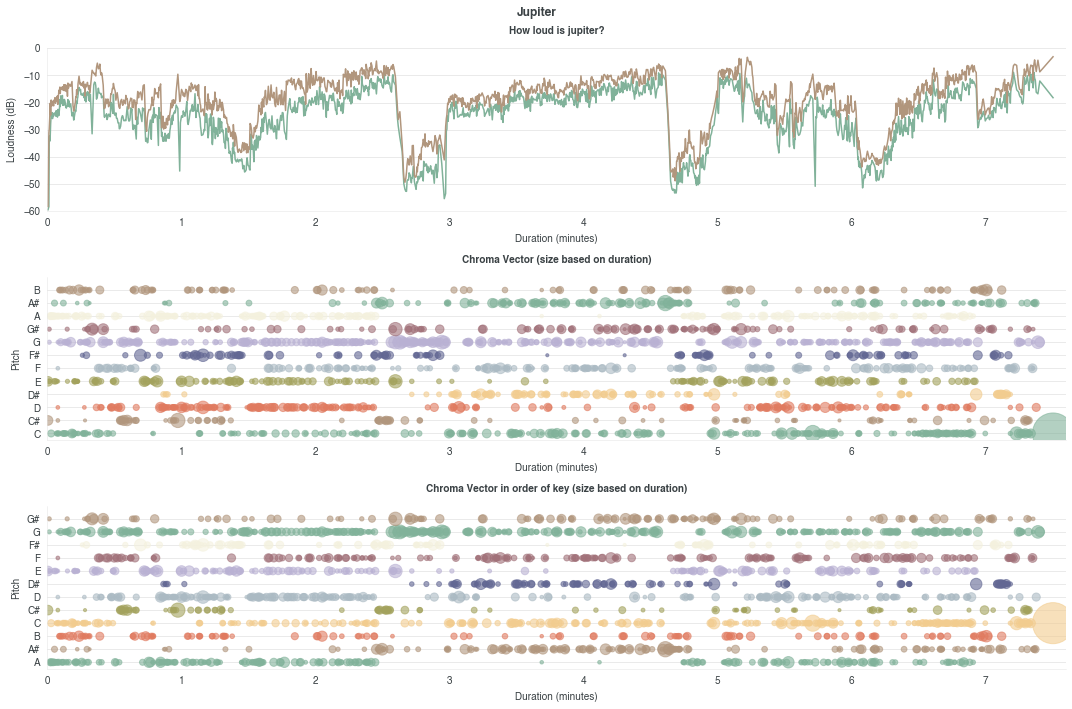

In [13]:
fix, axes = plt.subplots(3, 1, figsize=[15, 10])
plt.suptitle("Jupiter")

for ax in axes:
    ax.set_xlim(0, jupiter["duration"])
    ax.set_xticks(np.arange(0, jupiter["duration"], 60))
    ax.set_xticklabels([int(s / 60) for s in np.arange(0, jupiter["duration"], 60)])
    ax.set_xlabel("Duration (minutes)")


ax = axes[0]
ax.set_title("How loud is jupiter?")
ax.set_ylim(-60, 0)
ax.set_ylabel("Loudness (dB)")

ax.plot(
    jupiter_segments["start"] + 0.5 * jupiter_segments["duration"],
    jupiter_segments["loudness_start"],
)
ax.plot(
    jupiter_segments["start"] + 0.5 * jupiter_segments["duration"],
    jupiter_segments["loudness_max"],
)


ax = axes[1]
ax.set_title("Chroma Vector (size based on duration)")
ax.set_ylim(-0.5, 12)
ax.set_yticks(np.arange(0, 12))
ax.set_yticklabels(PITCHES)
ax.set_ylabel("Pitch")
for index, pitch in enumerate(PITCHES):
    # Filter pitches to have a threshold of 80% because Matplotlib doesn't support dynamic alpha
    p = jupiter_pitches[jupiter_pitches[pitch] > 0.8]
    ax.scatter(
        x=p["start"] + 0.5 * p["duration"],
        y=np.repeat(index, p.shape[0]),
        s=150 * p["duration"],
        alpha=0.6,
    )

ax = axes[2]
key = jupiter_sections.key.iloc[0]
ax.set_title("Chroma Vector in order of key (size based on duration)")
ax.set_ylim(-0.5, 12)
ax.set_yticks(np.arange(0, 12))
ax.set_yticklabels(PITCHES[key:] + PITCHES[:key])
ax.set_ylabel("Pitch")
for index, pitch in enumerate(PITCHES[key:] + PITCHES[:key]):
    # Filter pitches to have a threshold of 80% because Matplotlib doesn't support dynamic alpha
    p = jupiter_pitches[jupiter_pitches[pitch] > 0.8]
    ax.scatter(
        x=p["start"] + 0.5 * p["duration"],
        y=np.repeat(index, p.shape[0]),
        s=150 * p["duration"],
        alpha=0.6,
    )

plt.savefig("../img/jupiter_analysis.png")

In the 3rd visualization, I rearranged the pitches so that it would start on the [Tonic](https://en.wikipedia.org/wiki/Tonic_(music)), which is A minor. I think using the first section's key is better than using the overall piece's key that Spotify provides. Spotify says that Jupiter is in the key of G, which I believe is incorrect. The section also changes to E-flat in the middle, which is easier to see in the 3rd visualization (since the bottom note is gone).

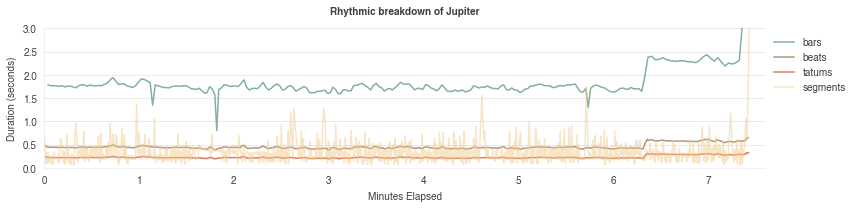

In [14]:
fix, ax = plt.subplots(1, figsize=[12, 3])

ax.set_title("Rhythmic breakdown of Jupiter")
ax.set_xlim(0, jupiter["duration"])
ax.set_xticks(np.arange(0, jupiter["duration"], 60))
ax.set_xticklabels([int(s / 60) for s in np.arange(0, jupiter["duration"], 60)])
ax.set_xlabel("Minutes Elapsed")

ax.set_ylim(0, 3)
ax.set_ylabel("Duration (seconds)")


ax.plot(
    jupiter_bars["start"] + 0.5 * jupiter_bars["duration"], jupiter_bars["duration"]
)
ax.plot(
    jupiter_beats["start"] + 0.5 * jupiter_beats["duration"], jupiter_beats["duration"]
)
ax.plot(
    jupiter_tatums["start"] + 0.5 * jupiter_tatums["duration"],
    jupiter_tatums["duration"],
)
ax.plot(
    jupiter_segments["start"] + 0.5 * jupiter_segments["duration"],
    jupiter_segments["duration"],
    alpha=0.5,
)

ax.legend(["bars", "beats", "tatums", "segments"], bbox_to_anchor=(1, 1))
plt.savefig("../img/jupiter_rhythm.png")
plt.show()

In Spotify, pieces are broken down by sections, bars, beats, tatums, and segments. Sections and segments are the musical phrases and don't necessarily stick within the boundaries defined by the rhymic features (bars, beats, tatums).

After this discovery, I have decided to use the following data points:
* Breakdown of sections
* Breakdown of bars, beats, and tatums (section's time signature could help or validate)
* Pitch class for segments based on threshold of 0.8 for the chroma feature
* Loudness throughout the piece
* Key for the first section (usually the starting chord is more accurate than the middle/end)
* Popularity by piece

#### Final Data Cleaning
* Change `key` to match the first section's key.
* Make sure all fields are camelCase.

In [90]:
def rename_dict_key(d: dict):
    """Rename key name in dictionary.
    Parameters
    ----------
    d : dict
        dictionary
    """
    keys = list(d.keys())
    for key in keys:
        new_key_split = key.split("_")
        new_key = new_key_split[0] + "".join(ele.title() for ele in new_key_split[1:])
        d[new_key] = d.pop(key)


for index, row in df.iterrows():
    df.loc[index, "key"] = row["analysis"]["sections"][0]["key"]
    for key in df.loc[0, "analysis"].keys():
        for record in df.loc[0, "analysis"][key]:
            rename_dict_key(record)

<IPython.core.display.Javascript object>

In [93]:
# Save as JSON file
with open("data.json", "w") as file:
    json.dump(tracks, file)

<IPython.core.display.Javascript object>